<a href="https://colab.research.google.com/github/ennie191/NetraAI/blob/main/NetrAi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload() # Choose the kaggle.json file you downloaded

# Make directory to store the key
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle competitions download -c aptos2019-blindness-detection

429 Client Error: Too Many Requests for url: https://www.kaggle.com/api/v1/competitions/data/download-all/aptos2019-blindness-detection


In [ ]:
!unzip -q aptos2019-blindness-detection.zip -d .

unzip:  cannot find or open aptos2019-blindness-detection.zip, aptos2019-blindness-detection.zip.zip or aptos2019-blindness-detection.zip.ZIP.


In [ ]:
!ls

kaggle.json  sample_data


In [ ]:
!kaggle competitions download -c aptos2019-blindness-detection

429 Client Error: Too Many Requests for url: https://www.kaggle.com/api/v1/competitions/data/download-all/aptos2019-blindness-detection


In [ ]:
!ls

kaggle.json  sample_data


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir -p /content/drive/My\ Drive/Kaggle/APTOS2019

In [ ]:
%cd /content/drive/My\ Drive/Kaggle/APTOS2019

In [ ]:
# Download just the csv file
!kaggle competitions download -c aptos2019-blindness-detection -f train.csv

In [ ]:
import os
import pandas as pd
import time # Import the time library
from google.colab import drive

# --- 1. SETUP THE ENVIRONMENT ---
# This just confirms your location, no need to remount
KAGGLE_DIR = "/content/drive/My Drive/Kaggle/APTOS2019_Subset"
%cd $KAGGLE_DIR
print(f"Current directory: {os.getcwd()}")


# --- 2. DOWNLOAD THE DATA SUBSET (WITH DELAY) ---

# Load the csv to get the image names
df = pd.read_csv('train.csv')

# --- How many images to download? ---
NUM_IMAGES_TO_DOWNLOAD = 500
# -----------------------------------

# Get the list of the first 500 image filenames
image_list = df['id_code'].head(NUM_IMAGES_TO_DOWNLOAD).tolist()

# Ensure the 'train_images' directory exists
os.makedirs('train_images', exist_ok=True)

# Loop through the list and download each image one by one
print(f"\nStarting download of {NUM_IMAGES_TO_DOWNLOAD} images (with delay to avoid errors)...")
for i, image_id in enumerate(image_list):
    filename = f"{image_id}.png"
    filepath = os.path.join('train_images', filename)

    # Only download if the file doesn't already exist
    if not os.path.exists(filepath):
        # Use the -p flag to specify the output path and --quiet to reduce output
        !kaggle competitions download -c aptos2019-blindness-detection -f train_images/{filename} -p train_images --quiet

        # --- THIS IS THE FIX ---
        # Pause for 1 second to respect the API rate limit
        time.sleep(1)

    # Print progress every 25 images
    if (i + 1) % 25 == 0:
        print(f"  Downloaded {i + 1} / {NUM_IMAGES_TO_DOWNLOAD} images...")


print("\n✅ Download of image subset complete!")

In [ ]:
# Cell 1: Import Libraries and Load Data
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Define the base directory where your data is stored
DATA_DIR = "/content/drive/My Drive/Kaggle/APTOS2019_Subset"
TRAIN_IMG_DIR = os.path.join(DATA_DIR, "train_images")

# Load the csv file
df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))

# We are only using the first 500 images we downloaded
df_subset = df.head(500)

# Create a new column with the full path to each image
df_subset['image_path'] = df_subset['id_code'].apply(lambda x: os.path.join(TRAIN_IMG_DIR, f'{x}.png'))

# Split the data into training (80%) and validation (20%) sets
train_df, val_df = train_test_split(
    df_subset,
    test_size=0.2,      # 20% of the data will be used for validation
    random_state=42,    # Ensures the split is the same every time
    stratify=df_subset['diagnosis'] # Ensures the proportion of each class is the same in both sets
)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
train_df.head()

In [ ]:
# Cell 2: Create TensorFlow Datasets
IMG_SIZE = 224 # The standard input size for MobileNet
BATCH_SIZE = 32 # How many images to process at once

def load_and_preprocess_image(path, label):
    # Read the image file
    image = tf.io.read_file(path)
    # Decode the image to a tensor
    image = tf.image.decode_png(image, channels=3)
    # Resize the image to our desired size
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    # Normalize pixel values from [0, 255] to [0, 1]
    image = image / 255.0
    return image, label

# Create the training dataset
train_ds = tf.data.Dataset.from_tensor_slices((train_df['image_path'].values, train_df['diagnosis'].values))
train_ds = train_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(buffer_size=len(train_df)).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

# Create the validation dataset
val_ds = tf.data.Dataset.from_tensor_slices((val_df['image_path'].values, val_df['diagnosis'].values))
val_ds = val_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

print("✅ Datasets created successfully.")

In [ ]:
# Cell 3: Build the Model
from tensorflow import keras
from tensorflow.keras import layers

# Define data augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
], name="data_augmentation")

# Define the input shape
input_shape = (IMG_SIZE, IMG_SIZE, 3)

# Get the pre-trained base model
base_model = tf.keras.applications.MobileNetV3Small(
    input_shape=input_shape,
    include_top=False, # We don't need the final classification layer from the original model
    weights='imagenet'
)

# Freeze the base model so its weights are not updated during initial training
base_model.trainable = False

# Create the final model by adding our own layers on top of the base model
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs) # Apply augmentation
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x) # Helps prevent overfitting
outputs = layers.Dense(5, activation='softmax')(x) # 5 classes for DR (0-4)
model = keras.Model(inputs, outputs)

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy', # Use this loss function for integer labels
    metrics=['accuracy']
)

# Print a summary of our model architecture
model.summary()

In [ ]:
# Cell 4: Train the Model
EPOCHS = 20

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

print("\n🎉 Model training complete!")

In [ ]:
# Cell to Fix the DataFrame
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# Define the directories
DATA_DIR = "/content/drive/My Drive/Kaggle/APTOS2019_Subset"
TRAIN_IMG_DIR = os.path.join(DATA_DIR, "train_images")

# 1. Get the list of filenames that were actually downloaded
downloaded_images = os.listdir(TRAIN_IMG_DIR)
# Clean up the names to get the id_code (e.g., 'xyz.png' -> 'xyz')
downloaded_ids = [img.replace('.png', '') for img in downloaded_images]

# 2. Load the original full CSV
full_df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))

# 3. Filter the full DataFrame to ONLY include rows for the images we have
# This is the crucial step
df_correct = full_df[full_df['id_code'].isin(downloaded_ids)].copy()

# 4. Create the full image path again
df_correct['image_path'] = df_correct['id_code'].apply(lambda x: os.path.join(TRAIN_IMG_DIR, f'{x}.png'))

# 5. Re-run the train-test split on the corrected DataFrame
train_df, val_df = train_test_split(
    df_correct,
    test_size=0.2,
    random_state=42,
    stratify=df_correct['diagnosis']
)

print("✅ DataFrame has been corrected based on actual downloaded files.")
print(f"New training samples: {len(train_df)}")
print(f"New validation samples: {len(val_df)}")

In [ ]:
# Cell to find and remove ALL bad images by verifying them
import os
from PIL import Image
from tqdm.notebook import tqdm # To show a nice progress bar

# Define the directory where your images are stored
TRAIN_IMG_DIR = "/content/drive/My Drive/Kaggle/APTOS2019_Subset/train_images"

bad_files = []
print(f"Deep scanning {len(os.listdir(TRAIN_IMG_DIR))} files in {TRAIN_IMG_DIR}...")

# Loop through all downloaded images with a progress bar
for filename in tqdm(os.listdir(TRAIN_IMG_DIR)):
    filepath = os.path.join(TRAIN_IMG_DIR, filename)

    try:
        # Attempt to open the image file
        img = Image.open(filepath)
        # Verify that the image data can be read
        img.verify()
    except Exception as e:
        # If any error occurs, the file is corrupted
        print(f"Found corrupted file: {filename}, Error: {e}")
        bad_files.append(filepath)

# Report and delete the corrupted files
if len(bad_files) > 0:
    print(f"\nFound {len(bad_files)} corrupted files. Deleting them now...")
    for file_to_delete in bad_files:
        print(f"  - Deleting {os.path.basename(file_to_delete)}")
        os.remove(file_to_delete)
    print("\n✅ All corrupted files have been removed.")
else:
    print("\n✅ No corrupted files found during deep scan.")

In [ ]:
# Cell 1: Create and move to the new directory
import os
from google.colab import drive

# Mount Google Drive if not already mounted
drive.mount('/content/drive', force_remount=True)

# Define and create the new directory for the full dataset
FULL_DATA_DIR = "/content/drive/My Drive/Kaggle/APTOS2019_Full"
os.makedirs(FULL_DATA_DIR, exist_ok=True)

# Change the current directory to the new folder
%cd $FULL_DATA_DIR

print(f"✅ Successfully moved to: {os.getcwd()}")

Mounted at /content/drive
/content/drive/My Drive/Kaggle/APTOS2019_Full
✅ Successfully moved to: /content/drive/My Drive/Kaggle/APTOS2019_Full


In [ ]:
# Cell to correctly configure the Kaggle API key
import os
from google.colab import files

# --- 1. DEFINE THE OFFICIAL KAGGLE DIRECTORY ---
KAGGLE_CONFIG_DIR = os.path.join(os.path.expanduser("~"), ".kaggle")
# This resolves to /root/.kaggle/ in Colab

# --- 2. DEFINE THE PATH TO YOUR API KEY ---
# Assumes your kaggle.json is in your current Google Drive folder
# e.g., /content/drive/My Drive/Kaggle/IDRiD_Dataset/kaggle.json
API_KEY_PATH = "kaggle.json"

# --- 3. CHECK FOR AND UPLOAD THE KEY IF NEEDED ---
if not os.path.exists(API_KEY_PATH):
    print("Could not find kaggle.json in the current directory.")
    print("Please upload your kaggle.json API key:")
    files.upload() # Prompt to upload the file

# --- 4. CREATE THE DIRECTORY AND COPY THE KEY ---
os.makedirs(KAGGLE_CONFIG_DIR, exist_ok=True)
!cp {API_KEY_PATH} {KAGGLE_CONFIG_DIR}

# --- 5. SET SECURE PERMISSIONS ---
# This step is required by the Kaggle API
!chmod 600 {os.path.join(KAGGLE_CONFIG_DIR, "kaggle.json")}

print(f"\n✅ Kaggle API key has been successfully configured at: {KAGGLE_CONFIG_DIR}")


✅ Kaggle API key has been successfully configured at: /root/.kaggle


In [ ]:
# Cell to run after manual upload is complete
import os

# Define and move to the correct directory
FULL_DATA_DIR = "/content/drive/My Drive/Kaggle/APTOS2019_Full"
%cd $FULL_DATA_DIR

# 1. Verify the file exists (you should see the .zip file listed)
print("Verifying file presence...")
!ls -lh

# 2. Unzip the file
print("\nUnzipping the dataset... this will take several minutes.")
!unzip -q aptos2019-blindness-detection.zip

print("\n✅ Unzip complete! All images are now ready for training.")

/content/drive/My Drive/Kaggle/APTOS2019_Full
Verifying file presence...
total 9.6G
-rw------- 1 root root 9.6G Oct 19 16:05 aptos2019-blindness-detection.zip
-rw------- 1 root root   64 Oct 19 15:26 kaggle.json
-rw------- 1 root root  29K Dec 18  2019 sample_submission.csv
-rw------- 1 root root  25K Dec 18  2019 test.csv
drwx------ 2 root root 4.0K Oct 19 16:39 test_images
-rw------- 1 root root  54K Dec 18  2019 train.csv
drwx------ 2 root root 4.0K Oct 19 16:41 train_images

Unzipping the dataset... this will take several minutes.
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 
✅ Unzip complete! All images are now ready for training.


In [ ]:
# Cell 1: Prepare the Full Dataset
import tensorflow as tf
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split

# Define the base directory for the full dataset
DATA_DIR = "/content/drive/My Drive/Kaggle/APTOS2019_Full"
TRAIN_IMG_DIR = os.path.join(DATA_DIR, "train_images")

# Load the csv file
df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))

# Create a new column with the full path to each image
df['image_path'] = df['id_code'].apply(lambda x: os.path.join(TRAIN_IMG_DIR, f'{x}.png'))

# Split the data into training (80%) and validation (20%) sets
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['diagnosis'] # Stratify to maintain class balance
)

# --- Create TensorFlow Datasets ---
IMG_SIZE = 224
BATCH_SIZE = 32

def load_and_preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = image / 255.0
    return image, label

# Create the training dataset
train_ds = tf.data.Dataset.from_tensor_slices((train_df['image_path'].values, train_df['diagnosis'].values))
train_ds = train_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(buffer_size=len(train_df)).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

# Create the validation dataset
val_ds = tf.data.Dataset.from_tensor_slices((val_df['image_path'].values, val_df['diagnosis'].values))
val_ds = val_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

print("✅ Full dataset is ready for training.")
print(f"Total training samples: {len(train_df)}")
print(f"Total validation samples: {len(val_df)}")

✅ Full dataset is ready for training.
Total training samples: 2929
Total validation samples: 733


In [ ]:
# Cell to calculate class weights
from sklearn.utils import class_weight
import numpy as np

# Use the full training dataframe to calculate weights
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_df['diagnosis']),
    y=train_df['diagnosis'].values
)

# Create a dictionary mapping class indices to their calculated weights
class_weight_dict = dict(enumerate(class_weights))

print("Class Weights have been calculated to penalize the model for misclassifying rare classes:")
print(class_weight_dict)

Class Weights have been calculated to penalize the model for misclassifying rare classes:
{0: np.float64(0.4056786703601108), 1: np.float64(1.979054054054054), 2: np.float64(0.7331664580725907), 3: np.float64(3.803896103896104), 4: np.float64(2.4822033898305085)}


In [ ]:
# Cell 1: Prepare Data for Binary Classification
import tensorflow as tf
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

# Define the base directory for the full dataset
DATA_DIR = "/content/drive/My Drive/Kaggle/APTOS2019_Full"
TRAIN_IMG_DIR = os.path.join(DATA_DIR, "train_images")

# Load the csv file
df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))

# --- THIS IS THE KEY CHANGE ---
# Create a new binary label column.
# If diagnosis is 0, the new label is 0.
# If diagnosis is > 0 (1, 2, 3, or 4), the new label is 1.
df['binary_diagnosis'] = df['diagnosis'].apply(lambda x: 1 if x > 0 else 0)
print("Created new binary labels:")
print(df['binary_diagnosis'].value_counts())
# -----------------------------

# Create a new column with the full path to each image
df['image_path'] = df['id_code'].apply(lambda x: os.path.join(TRAIN_IMG_DIR, f'{x}.png'))

# Split the data, stratifying on the NEW binary label
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['binary_diagnosis']
)

# --- Define IMG_SIZE and BATCH_SIZE ---
IMG_SIZE = 224
BATCH_SIZE = 32

# --- Create TensorFlow Datasets (without normalization for EfficientNet) ---
def load_and_preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    return image, label

train_ds = tf.data.Dataset.from_tensor_slices((train_df['image_path'].values, train_df['binary_diagnosis'].values))
train_ds = train_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(buffer_size=len(train_df)).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_df['image_path'].values, val_df['binary_diagnosis'].values))
val_ds = val_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

# --- Calculate Class Weights for the binary problem ---
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_df['binary_diagnosis']),
    y=train_df['binary_diagnosis'].values
)
class_weight_dict = dict(enumerate(class_weights))

print("\nClass weights for the binary problem:")
print(class_weight_dict)
print("\n✅ Binary dataset is ready for training.")

Created new binary labels:
binary_diagnosis
1    1857
0    1805
Name: count, dtype: int64

Class weights for the binary problem:
{0: np.float64(1.014196675900277), 1: np.float64(0.9861952861952862)}

✅ Binary dataset is ready for training.


In [ ]:
# Cell 2: Build and Train the Binary Model (with keep-alive + autosave)
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import threading, time, os
import tensorflow as tf

# --- Keep-Alive Thread ---
def keep_alive():
    while True:
        time.sleep(120)  # every 2 minutes
        print("✅ Still running...")

threading.Thread(target=keep_alive, daemon=True).start()

# --- Mount Drive (optional but recommended) ---
from google.colab import drive
drive.mount('/content/drive')

SAVE_PATH = '/content/drive/MyDrive/binary_model_checkpoint.keras'

# --- 1. BUILD THE MODEL for Binary Classification ---
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
], name="data_augmentation")

input_shape = (IMG_SIZE, IMG_SIZE, 3)
base_model = tf.keras.applications.EfficientNetB0(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

# --- 2. COMPILE & TRAIN THE TOP LAYER ONLY ---
print("--- Phase 1: Training the Classifier Head ---")
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

checkpoint_cb = keras.callbacks.ModelCheckpoint(
    SAVE_PATH, save_best_only=True
)

history_phase1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weight_dict,
    callbacks=[checkpoint_cb]
)

# --- 3. PREPARE FOR FINE-TUNING ---
print("\n--- Phase 2: Preparing for Fine-Tuning ---")
base_model.trainable = True
for layer in base_model.layers[:-60]:
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# --- 4. FINE-TUNE THE MODEL ---
print("\n--- Phase 2: Starting Fine-Tuning ---")
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

history_phase2 = model.fit(
    train_ds,
    validation_data=val_ds,
    initial_epoch=history_phase1.epoch[-1] + 1,
    epochs=30,
    callbacks=[early_stopping, checkpoint_cb],
    class_weight=class_weight_dict
)

print("\n🎉 Binary model fine-tuning complete! Check Drive for autosaved checkpoints.")

# --- 5. VISUALIZE COMBINED RESULTS ---
acc = history_phase1.history['accuracy'] + history_phase2.history['accuracy']
val_acc = history_phase1.history['val_accuracy'] + history_phase2.history['val_accuracy']
loss = history_phase1.history['loss'] + history_phase2.history['loss']
val_loss = history_phase1.history['val_loss'] + history_phase2.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.axvline(x=len(history_phase1.history['accuracy']) - 1, color='r', linestyle='--', label='Start of Fine-Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.axvline(x=len(history_phase1.history['accuracy']) - 1, color='r', linestyle='--', label='Start of Fine-Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
--- Phase 1: Training the Classifier Head ---
Epoch 1/10
✅ Still running...
✅ Still running...
38/92 ━━━━━━━━━━━━━━━━━━━━ 2:08 2s/step - accuracy: 0.6997 - loss: 0.5920✅ Still running...
89/92 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.7758 - loss: 0.5077✅ Still running...
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7786 - loss: 0.5040✅ Still running...
92/92 ━━━━━━━━━━━━━━━━━━━━ 607s 4s/step - accuracy: 0.7795 - loss: 0.5028 - val_accuracy: 0.8854 - val_loss: 0.3273
Epoch 2/10
✅ Still running...
✅ Still running...
34/92 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - accuracy: 0.9127 - loss: 0.2502✅ Still running...
88/92 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.9174 - loss: 0.2434 ✅ Still running...
92/92 ━━━━━━━━━━━━━━━━━━━━ 586s 3s/step - accuracy: 0.9178 - loss: 0.2426 - val_accuracy: 0.9400 - val_loss: 0.2398
Epoch 3/10
✅ Still running...
✅ Still ru

In [ ]:
# Cell to Resume Training from a Checkpoint
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os

# --- 1. DEFINE PATHS AND CALLBACKS ---
SAVE_PATH = '/content/drive/MyDrive/binary_model_checkpoint.keras'

# Define the callbacks again
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    SAVE_PATH, save_best_only=True
)
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

# --- 2. LOAD YOUR BEST SAVED MODEL ---
print(f"Loading best model from: {SAVE_PATH}")
model = keras.models.load_model(SAVE_PATH)

# --- 3. RE-COMPILE FOR FINE-TUNING ---
# We re-compile to ensure the optimizer is set correctly
print("Compiling model for fine-tuning...")
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5), # Use the low fine-tuning learning rate
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# --- 4. RESUME FINE-TUNING ---
print("\n--- Resuming Fine-Tuning from Epoch 13 ---")

# We set initial_epoch to 13 to continue the count
history_resume = model.fit(
    train_ds,
    validation_data=val_ds,
    initial_epoch=13, # Start counting from where you left off
    epochs=30, # Keep the original target
    callbacks=[early_stopping, checkpoint_cb],
    class_weight=class_weight_dict
)

print("\n🎉 Model fine-tuning complete!")

# --- 5. VISUALIZE RESULTS ---
# Note: This will only show the history from the resumed session.
# To get the full graph, you would need to combine the old and new history.
print("Plotting results from the resumed session...")
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_resume.history['accuracy'], label='Training Accuracy')
plt.plot(history_resume.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Resumed Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history_resume.history['loss'], label='Training Loss')
plt.plot(history_resume.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Resumed Training and Validation Loss')
plt.show()

Loading best model from: /content/drive/MyDrive/binary_model_checkpoint.keras
Compiling model for fine-tuning...

--- Resuming Fine-Tuning from Epoch 13 ---
Epoch 14/30


Loading best model from: /content/drive/MyDrive/binary_model_checkpoint.keras
Making predictions on the validation set...
23/23 ━━━━━━━━━━━━━━━━━━━━ 110s 4s/step

--- Classification Report ---
              precision    recall  f1-score   support

       No DR       0.98      0.96      0.97       361
  DR Present       0.96      0.98      0.97       372

    accuracy                           0.97       733
   macro avg       0.97      0.97      0.97       733
weighted avg       0.97      0.97      0.97       733


--- Confusion Matrix ---


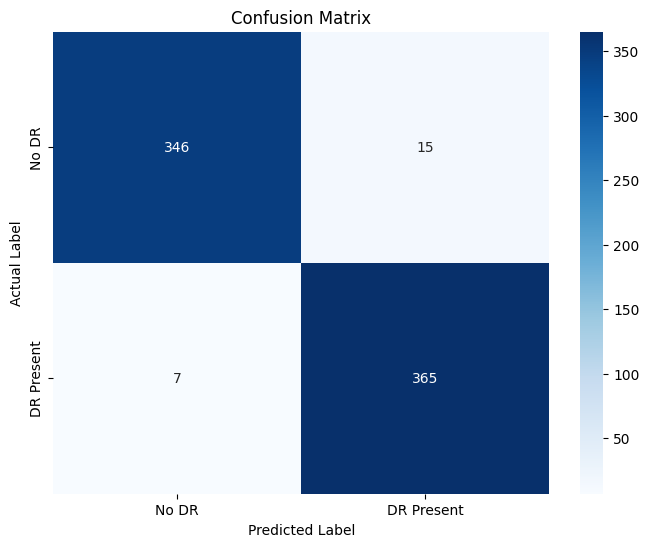

In [ ]:
# Cell to Evaluate the Final Model
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# --- 1. LOAD YOUR BEST SAVED MODEL ---
SAVE_PATH = '/content/drive/MyDrive/binary_model_checkpoint.keras'
print(f"Loading best model from: {SAVE_PATH}")
model = tf.keras.models.load_model(SAVE_PATH)

# --- 2. MAKE PREDICTIONS ON THE VALIDATION SET ---
# The val_ds dataset must be defined by re-running your data prep cell first.
print("Making predictions on the validation set...")
y_true = np.concatenate([y for x, y in val_ds], axis=0)
y_pred_proba = model.predict(val_ds)
y_pred = (y_pred_proba > 0.5).astype("int32").flatten()

# --- 3. PRINT THE CLASSIFICATION REPORT ---
# This gives you precision, recall, and f1-score.
print("\n--- Classification Report ---")
target_names = ['No DR', 'DR Present']
print(classification_report(y_true, y_pred, target_names=target_names))

# --- 4. VISUALIZE THE CONFUSION MATRIX ---
# This shows you exactly what kind of mistakes the model is making.
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
# Cell to unzip the manually uploaded file
import os

# Navigate to the correct directory
IDRID_DIR = "/content/drive/My Drive/Kaggle/IDRiD_Dataset"
%cd $IDRID_DIR

# --- THIS IS THE FIX ---
# Check for the specific filename you downloaded
source_zip_file = "archive (1).zip"
# --------------------

if os.path.exists(source_zip_file):
    # Rename it to be more descriptive (good practice)
    os.rename(source_zip_file, "idrid-dataset.zip")
    print(f"Renamed '{source_zip_file}' to idrid-dataset.zip")

# Unzip the file
print("\nUnzipping the dataset...")
!unzip -q idrid-dataset.zip

# Verify that the files are now there
print("\nVerification: Listing files in the directory...")
!ls

print("\n✅ Unzip complete! You are now ready to prepare the data for fine-tuning.")

/content/drive/My Drive/Kaggle/IDRiD_Dataset
Renamed 'archive (1).zip' to idrid-dataset.zip

Unzipping the dataset...

Verification: Listing files in the directory...
idrid-dataset.zip  idrid_labels.csv  Imagenes  kaggle.json

✅ Unzip complete! You are now ready to prepare the data for fine-tuning.


In [ ]:
# Cell 1 (Corrected): Prepare the IDRiD Dataset
import pandas as pd
import numpy as np
import os
import tensorflow as tf

# Define the directory where you unzipped the data
IDRID_DIR = "/content/drive/My Drive/Kaggle/IDRiD_Dataset"
%cd $IDRID_DIR

# --- THIS IS THE FIX ---
# Update the path to point to the nested 'Imagenes' folder
IDRID_LABEL_PATH = os.path.join(IDRID_DIR, 'idrid_labels.csv')
IDRID_IMG_DIR = os.path.join(IDRID_DIR, 'Imagenes', 'Imagenes') # Corrected path
# ----------------------

# Load the labels
idrid_df = pd.read_csv(IDRID_LABEL_PATH)

# Clean up column names if needed
if '# diagnosis' in idrid_df.columns:
    idrid_df = idrid_df.rename(columns={'# diagnosis': 'diagnosis'})

# Create the binary label (0 for No DR, 1 for DR Present)
idrid_df['binary_diagnosis'] = idrid_df['diagnosis'].apply(lambda x: 1 if x > 0 else 0)

# Create full image paths
idrid_df['image_path'] = idrid_df['id_code'].apply(lambda x: os.path.join(IDRID_IMG_DIR, f'{x}.jpg'))

# --- Define constants and the preprocessing function ---
IMG_SIZE = 224
BATCH_SIZE = 32

def load_and_preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    return image, label

# Create the TensorFlow Dataset
idrid_ds = tf.data.Dataset.from_tensor_slices((idrid_df['image_path'].values, idrid_df['binary_diagnosis'].values))
idrid_ds = idrid_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
idrid_ds = idrid_ds.shuffle(buffer_size=len(idrid_df)).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

print(f"\n✅ IDRiD dataset with {len(idrid_df)} images is ready for specialization.")

/content/drive/My Drive/Kaggle/IDRiD_Dataset

✅ IDRiD dataset with 455 images is ready for specialization.


In [ ]:
# Cell to find the correct folder structure
!ls -R "/content/drive/My Drive/Kaggle/IDRiD_Dataset"

'/content/drive/My Drive/Kaggle/IDRiD_Dataset':
idrid-dataset.zip  idrid_labels.csv  Imagenes  kaggle.json

'/content/drive/My Drive/Kaggle/IDRiD_Dataset/Imagenes':
Imagenes

'/content/drive/My Drive/Kaggle/IDRiD_Dataset/Imagenes/Imagenes':
IDRiD_001.jpg	   IDRiD_065.jpg      IDRiD_174.jpg  IDRiD_292.jpg
IDRiD_001test.jpg  IDRiD_065test.jpg  IDRiD_175.jpg  IDRiD_293.jpg
IDRiD_002.jpg	   IDRiD_066.jpg      IDRiD_176.jpg  IDRiD_294.jpg
IDRiD_003.jpg	   IDRiD_066test.jpg  IDRiD_177.jpg  IDRiD_295.jpg
IDRiD_004.jpg	   IDRiD_067.jpg      IDRiD_178.jpg  IDRiD_296.jpg
IDRiD_004test.jpg  IDRiD_067test.jpg  IDRiD_179.jpg  IDRiD_297.jpg
IDRiD_005.jpg	   IDRiD_068.jpg      IDRiD_180.jpg  IDRiD_298.jpg
IDRiD_005test.jpg  IDRiD_068test.jpg  IDRiD_181.jpg  IDRiD_299.jpg
IDRiD_006.jpg	   IDRiD_069.jpg      IDRiD_182.jpg  IDRiD_300.jpg
IDRiD_006test.jpg  IDRiD_069test.jpg  IDRiD_184.jpg  IDRiD_301.jpg
IDRiD_007.jpg	   IDRiD_070.jpg      IDRiD_185.jpg  IDRiD_302.jpg
IDRiD_007test.jpg  IDRiD_071.jpg    

In [ ]:
# Cell 2: Final Specialization and Saving
from tensorflow import keras

# Define the path to your best model from the APTOS training
APTOS_MODEL_PATH = '/content/drive/MyDrive/binary_model_checkpoint.keras'

# Load your powerful "generalist" model
print(f"Loading best model from: {APTOS_MODEL_PATH}")
model = keras.models.load_model(APTOS_MODEL_PATH)

# Re-compile the model with an extremely low learning rate for gentle fine-tuning
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-6), # Extremely low learning rate
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("\n--- Starting Final Fine-Tuning on IDRiD Dataset ---")

# Train for just a few epochs to specialize the model's knowledge
history_final = model.fit(
    idrid_ds,
    epochs=10 # Train for a small number of epochs on the new data
)

# --- Save the Final, Specialized Model ---
FINAL_MODEL_PATH = '/content/drive/MyDrive/final_specialized_netra_ai_model.h5'
model.save(FINAL_MODEL_PATH)

print(f"\n🎉🎉🎉 Final, specialized model is trained and saved!")
print(f"You can find your ultimate model at: {FINAL_MODEL_PATH}")

Loading best model from: /content/drive/MyDrive/binary_model_checkpoint.keras

--- Starting Final Fine-Tuning on IDRiD Dataset ---
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 111s 3s/step - accuracy: 0.8143 - loss: 0.4710
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.7826 - loss: 0.6055
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.8266 - loss: 0.4795
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.8218 - loss: 0.4210
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.7869 - loss: 0.5104
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 71s 3s/step - accuracy: 0.8105 - loss: 0.5432
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.8088 - loss: 0.5270
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step - accuracy: 0.7825 - loss: 0.5660
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 71s 3s/step - accuracy: 0.8041 - loss: 0.4982
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 68s 3s/step - accuracy: 0.8258 - loss: 0.4803


TypeError: cannot pickle 'module' object

In [ ]:
# Cell to correctly save the final model

# --- THIS IS THE FIX ---
# We are changing the file extension from .h5 to .keras
FINAL_MODEL_PATH = '/content/drive/MyDrive/final_specialized_netra_ai_model.keras'
# ----------------------

print(f"Saving the final, specialized model to the recommended '.keras' format...")
model.save(FINAL_MODEL_PATH)

print(f"\n✅ Final, specialized model successfully saved!")
print(f"You can find your ultimate model at: {FINAL_MODEL_PATH}")

Saving the final, specialized model to the recommended '.keras' format...

✅ Final, specialized model successfully saved!
You can find your ultimate model at: /content/drive/MyDrive/final_specialized_netra_ai_model.keras


In [ ]:
# Cell 1: Prepare the Validation Dataset
import tensorflow as tf
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split

# Define the base directory for the full APTOS dataset
DATA_DIR = "/content/drive/My Drive/Kaggle/APTOS2019_Full"
TRAIN_IMG_DIR = os.path.join(DATA_DIR, "train_images")

# Load the csv file
df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))

# Create the binary label
df['binary_diagnosis'] = df['diagnosis'].apply(lambda x: 1 if x > 0 else 0)
df['image_path'] = df['id_code'].apply(lambda x: os.path.join(TRAIN_IMG_DIR, f'{x}.png'))

# Split the data (we only need the validation part)
_, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['binary_diagnosis']
)

# --- Define constants and preprocessing ---
IMG_SIZE = 224
BATCH_SIZE = 32

def load_and_preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    return image, label

# Create the validation dataset
val_ds = tf.data.Dataset.from_tensor_slices((val_df['image_path'].values, val_df['binary_diagnosis'].values))
val_ds = val_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

print("✅ APTOS validation dataset is ready for evaluation.")

✅ APTOS validation dataset is ready for evaluation.


In [ ]:
# Cell 2: Evaluate the Final Specialized Model
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# --- 1. LOAD YOUR FINAL SPECIALIZED MODEL ---
FINAL_MODEL_PATH = '/content/drive/MyDrive/final_specialized_netra_ai_model.keras'
print(f"Loading best model from: {FINAL_MODEL_PATH}")
model = tf.keras.models.load_model(FINAL_MODEL_PATH)

# --- 2. MAKE PREDICTIONS ON THE VALIDATION SET ---
print("Making predictions on the validation set...")
y_true = np.concatenate([y for x, y in val_ds], axis=0)
y_pred_proba = model.predict(val_ds)
y_pred = (y_pred_proba > 0.5).astype("int32").flatten()

# --- 3. PRINT THE CLASSIFICATION REPORT ---
print("\n--- Classification Report ---")
target_names = ['No DR', 'DR Present']
print(classification_report(y_true, y_pred, target_names=target_names))

# --- 4. CALCULATE AND PRINT THE F1-SCORE EXPLICITLY ---
f1 = f1_score(y_true, y_pred, average='macro')
print(f"\nMacro Average F1-Score: {f1:.4f}")
print("The F1-Score is the harmonic mean of precision and recall, providing a single metric that balances both concerns.")

Loading best model from: /content/drive/MyDrive/final_specialized_netra_ai_model.keras
Making predictions on the validation set...
23/23 ━━━━━━━━━━━━━━━━━━━━ 109s 4s/step

--- Classification Report ---
              precision    recall  f1-score   support

       No DR       0.93      0.99      0.96       361
  DR Present       0.99      0.93      0.96       372

    accuracy                           0.96       733
   macro avg       0.96      0.96      0.96       733
weighted avg       0.96      0.96      0.96       733


Macro Average F1-Score: 0.9604
The F1-Score is the harmonic mean of precision and recall, providing a single metric that balances both concerns.
